In [1]:
import numpy as np
import pandas as pd
from statsmodels.sandbox.regression.gmm import IV2SLS
from statsmodels.regression.linear_model import OLS
from statsmodels.sandbox.sysreg import SUR
from linearmodels.system import SUR

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import het_breuschpagan

In [2]:
dataset = pd.read_excel("data/Dataset_SUR.xlsx")
dataset.head(10)

,Provinsi,Tahun,IPM,PDRB_PerKapita,JPM,Avr_LamaSekolah,Avr_AHH,TPT,UMR
0,ACEH,2020,73.29,31633,1648.82,9.33,69.975,5.995,3165031
1,SUMATERA UTARA,2020,73.62,54979,2640.01,9.54,69.150,5.810,2499423
2,SUMATERA BARAT,2020,74.29,43826,709.02,8.99,69.520,6.065,2484041
3,RIAU,2020,73.67,114167,974.61,9.14,71.650,5.620,2888564
4,JAMBI,2020,72.29,57958,565.90,8.55,71.170,4.695,2630162
5,SUMATERA SELATAN,2020,71.62,53843,2201.23,8.24,69.930,4.705,3043111
6,BENGKULU,2020,72.93,36552,608.58,8.84,69.370,3.575,2213604
7,LAMPUNG,2020,71.04,39290,2140.46,8.05,70.695,4.465,2432002
8,KEP. BANGKA BELITUNG,2020,72.74,52023,140.44,8.06,70.680,4.300,3230024
9,KEP. RIAU,2020,77.69,123465,274.58,10.12,69.990,8.160,3005460


In [3]:
data = dataset.drop(columns=["Provinsi", "Tahun"])
data.head()

,IPM,PDRB_PerKapita,JPM,Avr_LamaSekolah,Avr_AHH,TPT,UMR
0,73.29,31633,1648.82,9.33,69.975,5.995,3165031
1,73.62,54979,2640.01,9.54,69.150,5.810,2499423
2,74.29,43826,709.02,8.99,69.520,6.065,2484041
3,73.67,114167,974.61,9.14,71.650,5.620,2888564
4,72.29,57958,565.90,8.55,71.170,4.695,2630162


Text(0.5, 1.0, 'Correlation Plot')

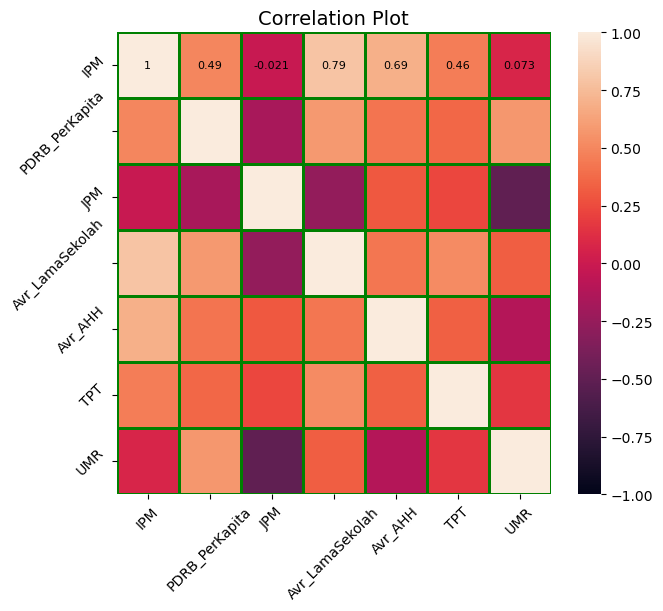

In [4]:
corr_matrix = data[["IPM","PDRB_PerKapita","JPM","Avr_LamaSekolah","Avr_AHH", "TPT", "UMR"]].corr()
corr_matrix
fig = plt.figure(figsize=(7,6))
sns.heatmap(corr_matrix,
            linewidths=0.75,
            linecolor='green',
            cbar=True,
            vmin=-1,
            vmax=1,
            annot=True,
            annot_kws={'size':8,'color':'black'})
plt.tick_params(labelsize=10,rotation=45)
plt.title("Correlation Plot",size=14)

In [5]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

x = data[["PDRB_PerKapita","JPM","Avr_LamaSekolah","Avr_AHH", "TPT", "UMR"]]
y = data["IPM"]


x = sm.add_constant(x)

# Fit model OLS
model = sm.OLS(y, x).fit()

# Hitung Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["Variable"] = x.columns
vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

# Cetak hasil VIF
print(vif_data)


          Variable          VIF
0            const  1487.930326
1   PDRB_PerKapita     2.613042
2              JPM     2.129188
3  Avr_LamaSekolah     2.537715
4          Avr_AHH     1.872883
5              TPT     1.826546
6              UMR     2.393552


In [6]:
y_log = np.log(y)
model_log = sm.OLS(y_log, x).fit()

_, p_value_bp_log, _, _ = het_breuschpagan(model_log.resid, model_log.model.exog)
print(f'Uji Breusch-Pagan : p-value = {p_value_bp_log}')
if p_value_bp_log > 0.05:
    print("Tidak terdapat heteroskedastisitas Pada Data")
else:
    print("Terdapat heteroskedastisitas Pada Data")

Uji Breusch-Pagan : p-value = 0.015609240425580526
Terdapat heteroskedastisitas Pada Data


In [7]:
# Menggunakan heteroskedasticity-robust standard errors
robust_model = sm.OLS(y, x).fit(cov_type='HC3')  # HC3 adalah salah satu opsi robust covariance
print(robust_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    IPM   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     34.80
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           6.06e-22
Time:                        18:54:26   Log-Likelihood:                -202.09
No. Observations:                 102   AIC:                             418.2
Df Residuals:                      95   BIC:                             436.6
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.2452      7.246     

In [8]:
# Transformasi logaritma
data["PDRB_Log"] = np.log(data["PDRB_PerKapita"])
data["UMR_Log"] = np.log(data["UMR"])

# Gunakan variabel baru dalam model
x = data[["PDRB_Log", "JPM", "Avr_LamaSekolah", "Avr_AHH", "TPT", "UMR_Log"]]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    IPM   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     58.46
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           9.67e-30
Time:                        18:54:26   Log-Likelihood:                -201.41
No. Observations:                 102   AIC:                             416.8
Df Residuals:                      95   BIC:                             435.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              37.4198     21.228     

In [9]:
# Estimasi model WLS dengan bobot
weights = 1 / model.resid**2  # Menggunakan residual kuadrat sebagai bobot
wls_model = sm.WLS(y, x, weights=weights).fit()

print(wls_model.summary())

                            WLS Regression Results                            
Dep. Variable:                    IPM   R-squared:                       0.964
Model:                            WLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     428.5
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           1.82e-66
Time:                        18:54:26   Log-Likelihood:                -151.33
No. Observations:                 102   AIC:                             316.7
Df Residuals:                      95   BIC:                             335.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              37.9742      5.741     

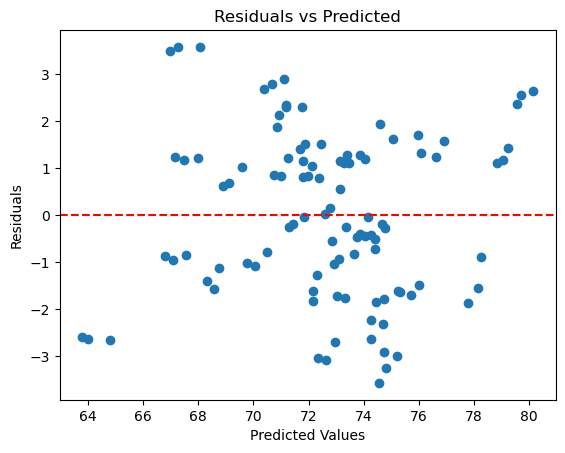

In [10]:
import matplotlib.pyplot as plt

# Scatter plot residual vs prediksi
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()


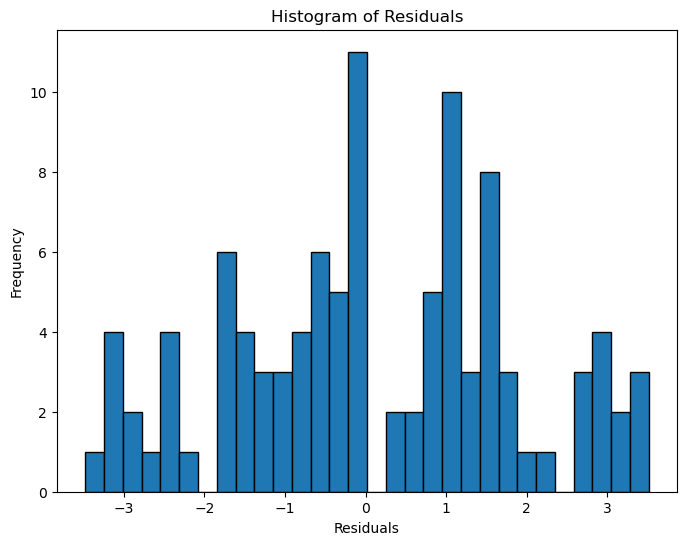

In [11]:
residuals = wls_model.resid
fitted_values = wls_model.fittedvalues

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [ ]:
formula_eq1 = "IPM ~ PDRB_PerKapita + JPM + Avr_LamaSekolah + Avr_AHH + TPT + UMR"
formula_eq2 = "IPM ~ PDRB_PerKapita + JPM + Avr_LamaSekolah + Avr_AHH + TPT + UMR"

In [19]:
equations = {
    'Eq1': formula_eq1,
    'Eq2': formula_eq2
}

In [20]:
print(type(equations))

<class 'dict'>


In [21]:
print(data.columns)


Index(['IPM', 'PDRB_PerKapita', 'JPM', 'Avr_LamaSekolah', 'Avr_AHH', 'TPT',
       'UMR', 'PDRB_Log', 'UMR_Log'],
      dtype='object')


In [22]:
sur_model = SUR.from_formula(equations, data)
sur_results = sur_model.fit()
print(sur_results)

                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                   0.7831
No. Equations.:                     2   McElroy's R-squared:                 0.6772
No. Observations:                 102   Judge's (OLS) R-squared:             0.4248
Date:                Fri, Nov 29 2024   Berndt's R-squared:                  0.8352
Time:                        18:59:47   Dhrymes's R-squared:                 0.7831
                                        Cov. Estimator:                      robust
                                        Num. Constraints:                      None
                       Equation: Eq1, Dependent Variable: IPM                      
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
PDRB_PerKapita  -5.483e-06  4.832e-06    -1.1347     0.2565  -1.495e-05   3.